In [1]:
# Import 
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.dynamics import SheetModel as basemodel
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
#from tyssue.behaviors.sheet.apoptosis_events import apoptosis

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')

import matplotlib


In [2]:
from polarity.dynamics import model
from polarity.apoptosis import apoptosis
from polarity.dynamics import EllipsoidLameGeometry as geom
#from tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom


In [3]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test_apoptosis_20190712_one_fold_line_tension')

sim_save_dir = SIM_DIR

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [4]:
solver = QSSolver(with_t1=False, with_t3=False, with_collisions=False)

In [5]:
from tyssue.dynamics import units, effectors, model_factory
from polarity.dynamics import RadialTension
model = model_factory(
    [
        RadialTension,
        effectors.LineTension,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

In [12]:
# Create tissue tissue 

def load_before_apopto(anchor_tension=0):

    h5store = '../examples/superegg_final.hf5'

    datasets = load_datasets(h5store,
                             data_names=['face', 'vert', 'edge'])
    
    with open('../examples/superegg_final.json', 'r+') as fp:
        specs = json.load(fp)
    
    sheet = Sheet('spherical', datasets, specs)
    sheet.settings['geometry'] = "spherical"
    sheet.settings['lumen_volume_elasticity'] = 3.e-6
    #sheet.settings['lumen_prefered_vol'] = sheet.settings['lumen_prefered_vol'] - sheet.settings['lumen_prefered_vol']*10/100

    sheet.edge_df['line_tension'] = 40
    sheet.face_df['radial_tension'] = 0
    
    return sheet

sheet = load_before_apopto(0)

geom.update_all(sheet)



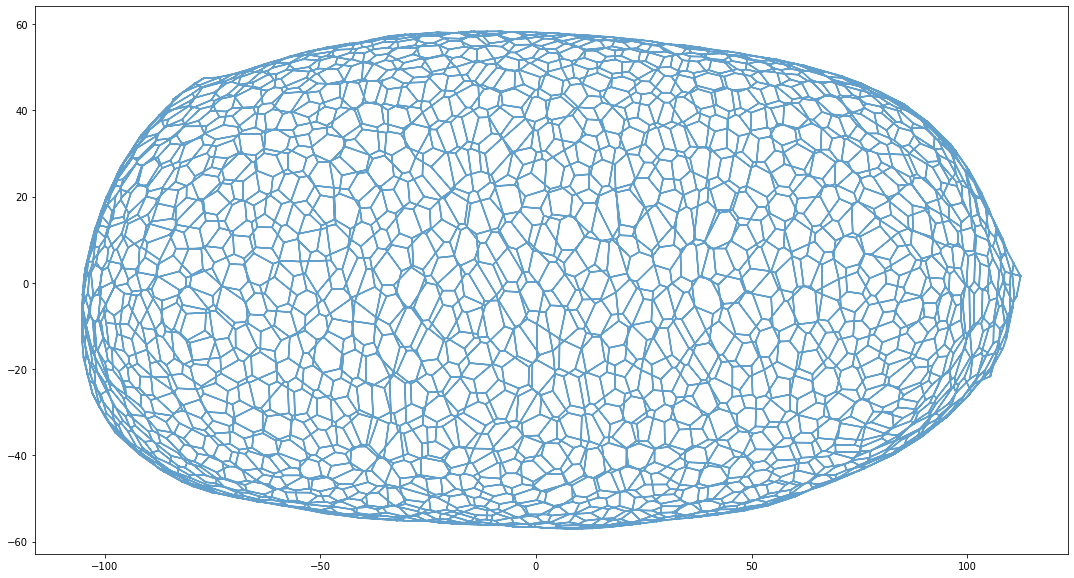

In [13]:
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)
fig.set_size_inches(18.5, 10.5, forward=True)

In [14]:
import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':sheet.vert_df.y*(sheet.vert_df.y>0),
                         'colormap':'viridis'})
fig



Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

before applying solver...


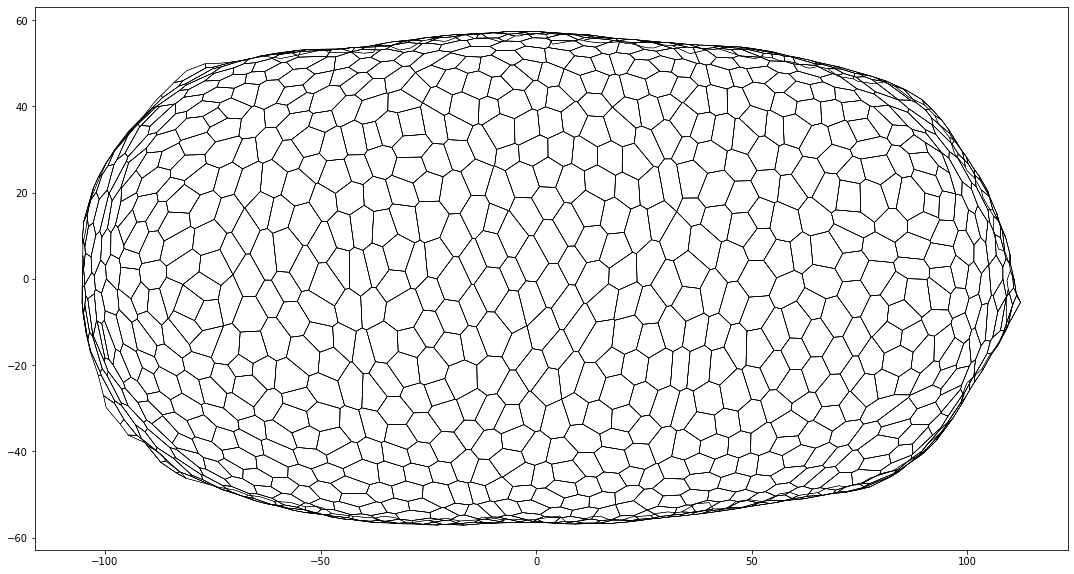

In [16]:
def decrease_linear_tension_lateral(sheet, face, line_tension):
    edges = sheet.edge_df[sheet.edge_df["face"] == face]
    for index, edge in edges.iterrows():
        angle_ = np.arctan2(
            sheet.edge_df.loc[edge.name, "dx"], sheet.edge_df.loc[edge.name, "dz"]
        )
        if ( ((np.abs(angle_) < np.pi/6) and (np.abs(angle_) > -np.pi/6)) or
            ((np.abs(angle_) > -np.pi/6) and (np.abs(angle_) < np.pi/6)) or
           ((np.abs(angle_) > 5*np.pi/6) and (np.abs(angle_) < 7*np.pi/6)) or
           ((np.abs(angle_) < -7*np.pi/6) and (np.abs(angle_) > -5*np.pi/6)) ):
        
            sheet.edge_df.loc[edge.name, "line_tension"] = 20
        else : 
            sheet.edge_df.loc[edge.name, "line_tension"] = 60
            
def decrease_linear_tension_dv(sheet, face, line_tension):
    edges = sheet.edge_df[sheet.edge_df["face"] == face]
    for index, edge in edges.iterrows():
        angle_ = np.arctan2(
            sheet.edge_df.loc[edge.name, "dy"], sheet.edge_df.loc[edge.name, "dz"]
        )
        if ( ((np.abs(angle_) < np.pi/6) and (np.abs(angle_) > -np.pi/6)) or
            ((np.abs(angle_) > -np.pi/6) and (np.abs(angle_) < np.pi/6)) or
           ((np.abs(angle_) > 5*np.pi/6) and (np.abs(angle_) < 7*np.pi/6)) or
           ((np.abs(angle_) < -7*np.pi/6) and (np.abs(angle_) > -5*np.pi/6)) ):
            sheet.edge_df.loc[edge.name, "line_tension"] = 20
        else : 
            sheet.edge_df.loc[edge.name, "line_tension"] = 60
        


            

def modif_line_tension(sheet):
    sheet.edge_df['id_']= sheet.edge_df.index

    sheet2 = sheet.extract_bounding_box(y_boundary=(30,150), z_boundary=(-100,100))
    [decrease_linear_tension_lateral(sheet2, i, 2) for i in range(sheet2.Nf)]
    for i in (sheet2.edge_df.index):
        sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=sheet2.edge_df.loc[i, 'line_tension']

    sheet2 = sheet.extract_bounding_box(y_boundary=(-150,-30), z_boundary=(-100,100))
    [decrease_linear_tension_lateral(sheet2, i, 2) for i in range(sheet2.Nf)]
    for i in (sheet2.edge_df.index):
        sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=sheet2.edge_df.loc[i, 'line_tension']


    sheet2 = sheet.extract_bounding_box(x_boundary=(-150,-30), z_boundary=(-100,100))
    [decrease_linear_tension_dv(sheet2, i, 2) for i in range(sheet2.Nf)]
    for i in (sheet2.edge_df.index):
        sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=sheet2.edge_df.loc[i, 'line_tension']


    sheet2 = sheet.extract_bounding_box(x_boundary=(30,150), z_boundary=(-100,100))
    [decrease_linear_tension_dv(sheet2, i, 2) for i in range(sheet2.Nf)]
    for i in (sheet2.edge_df.index):
        sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=sheet2.edge_df.loc[i, 'line_tension']


def draw_specs(sheet):
    sheet.edge_df['color']=0    
    cmap_edge = matplotlib.colors.ListedColormap(['lightslategrey', 'red', 'pink'])
    
    specs = {
        'face': {
            'visible': False,
            'color': 'lightslategrey',
            'alpha':0.8,
             },
        'edge': {
            'visible': True,
            'color': 'black',
            'colormap':'viridis',
            
       
        },
        'vert':{'visible':False}
        
    }
    return specs
print('before applying solver...')
modif_line_tension(sheet)

sheet2 = sheet.extract_bounding_box(x_boundary=(-10,150))
fig, ax = sheet_view(sheet2, coords=['z', 'y'], 
                    **draw_specs(sheet2))

fig.set_size_inches(18.5, 10.5, forward=True)
ax.grid(False)




after decrease linear tension


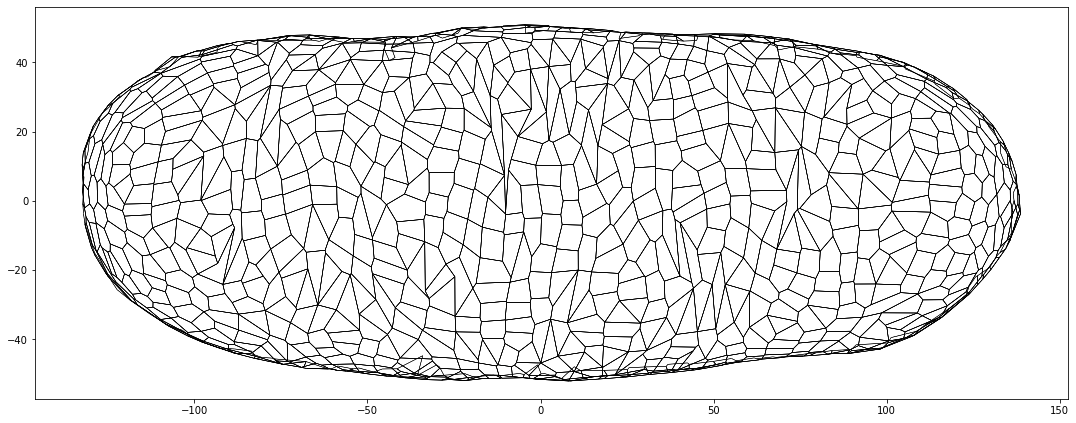

In [17]:
print('after decrease linear tension')

res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})
sheet2 = sheet.extract_bounding_box(x_boundary=(-10,150))
fig, ax = sheet_view(sheet2, coords=['z', 'y'], 
                    **draw_specs(sheet2))

fig.set_size_inches(18.5, 10.5, forward=True)
ax.grid(False)

In [18]:
sheet_after_line_tension = sheet.copy()

In [19]:
from tyssue.topology import all_rearangements
sheet.settings['threshold_length']=0.1
stop = 0
i = 0
while stop!=1:
    stop = (all_rearangements(sheet))
    modif_line_tension(sheet)
    res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})
    i += 1
    print(i, stop, sheet.edge_df[sheet.edge_df.length<0.1].shape)

1 2 (746, 37)
2 2 (1104, 37)
3 2 (808, 37)
4 2 (1022, 37)
5 2 (746, 37)
6 2 (998, 37)
7 2 (726, 37)
8 2 (978, 37)
9 2 (760, 37)
10 2 (920, 37)
11 2 (744, 37)
12 2 (914, 37)
13 2 (732, 37)
14 2 (860, 37)
15 2 (754, 37)
16 2 (882, 37)
17 2 (758, 37)
18 2 (848, 37)
19 2 (736, 37)
20 2 (852, 37)
21 2 (804, 37)
22 2 (832, 37)
23 2 (772, 37)
24 2 (890, 37)
25 2 (798, 37)
26 2 (778, 37)
27 2 (748, 37)
28 2 (840, 37)
29 2 (792, 37)
30 2 (860, 37)
31 2 (828, 37)
32 2 (842, 37)
33 2 (792, 37)
34 2 (852, 37)
35 2 (790, 37)
36 2 (872, 37)
37 2 (800, 37)
38 2 (788, 37)
39 2 (716, 37)
40 2 (832, 37)
41 2 (760, 37)
42 2 (824, 37)
43 2 (722, 37)
44 2 (798, 37)
45 2 (708, 37)
46 2 (782, 37)
47 2 (746, 37)
48 2 (792, 37)
49 2 (740, 37)
50 2 (754, 37)
51 2 (718, 37)
52 2 (756, 37)
53 2 (686, 37)
54 2 (732, 37)
55 2 (712, 37)
56 2 (726, 37)
57 2 (656, 37)
58 2 (720, 37)
59 2 (656, 37)
60 2 (712, 37)
61 2 (646, 37)
62 2 (698, 37)
63 2 (646, 37)
64 2 (726, 37)
65 2 (660, 37)
66 2 (710, 37)
67 2 (682, 37)
68

KeyboardInterrupt: 

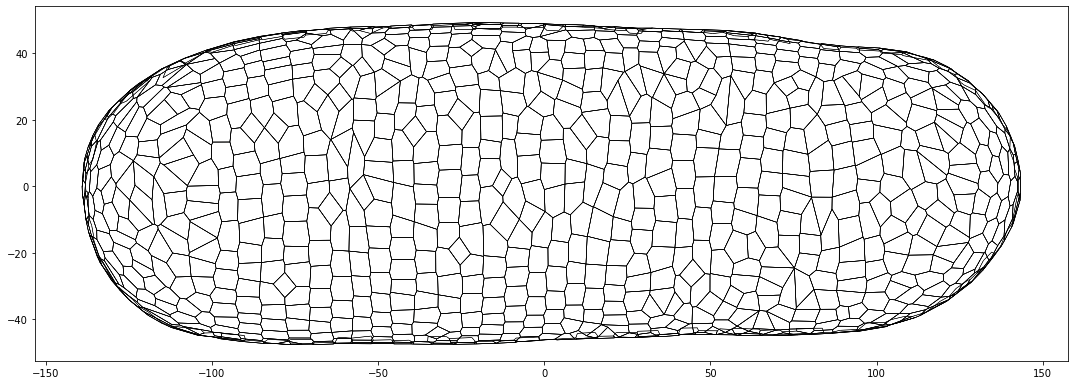

In [20]:
# Après les réarrangements et les corrections de tension linéaire...  
sheet2 = sheet.extract_bounding_box(x_boundary=(-10,150))
fig, ax = sheet_view(sheet2, coords=['z', 'y'], 
                    **draw_specs(sheet2))

fig.set_size_inches(18.5, 10.5, forward=True)
ax.grid(False)


In [ ]:
#Calcul angle 
sub_sheet = sheet.extract_bounding_box(z_boundary=(-100, 100))
angle=[]

for f in sub_sheet.face_df.index:
    list_edge = sub_sheet.edge_df[sub_sheet.edge_df.face==f]
    for e in list_edge.itertuples():
        a = e.length
        b = list_edge[list_edge.srce == e.trgt].length.values[0]
        c = np.sqrt((list_edge[list_edge.srce == e.trgt].tx.values[0]-e.sx)**2+(list_edge[list_edge.srce == e.trgt].ty.values[0]-e.sy)**2+(list_edge[list_edge.srce == e.trgt].tz.values[0]-e.sz)**2)
        angle.append(np.arccos((a**2 + b**2 - c**2)/(2*a*b))*180/np.pi)

plt.hist(angle, bins=20)        
        
        
    


In [29]:
hdf5.save_datasets('tissue_prepolarized.hf5', sheet)

In [ ]:
# Create tissue tissue 

def load_before_apopto(anchor_tension=0):

    h5store = 'tissue_prepolarized.hf5'

    datasets = load_datasets(h5store,
                             data_names=['face', 'vert', 'edge'])
    
    with open('../examples/superegg_final.json', 'r+') as fp:
        specs = json.load(fp)
    
    sheet = Sheet('spherical', datasets, specs)
    sheet.settings['geometry'] = "spherical"
    sheet.settings['lumen_volume_elasticity'] = 3.e-6
    #sheet.settings['lumen_prefered_vol'] = sheet.settings['lumen_prefered_vol'] - sheet.settings['lumen_prefered_vol']*10/100

    sheet.edge_df['line_tension'] = 1
    
    return sheet

sheet = load_before_apopto(0)



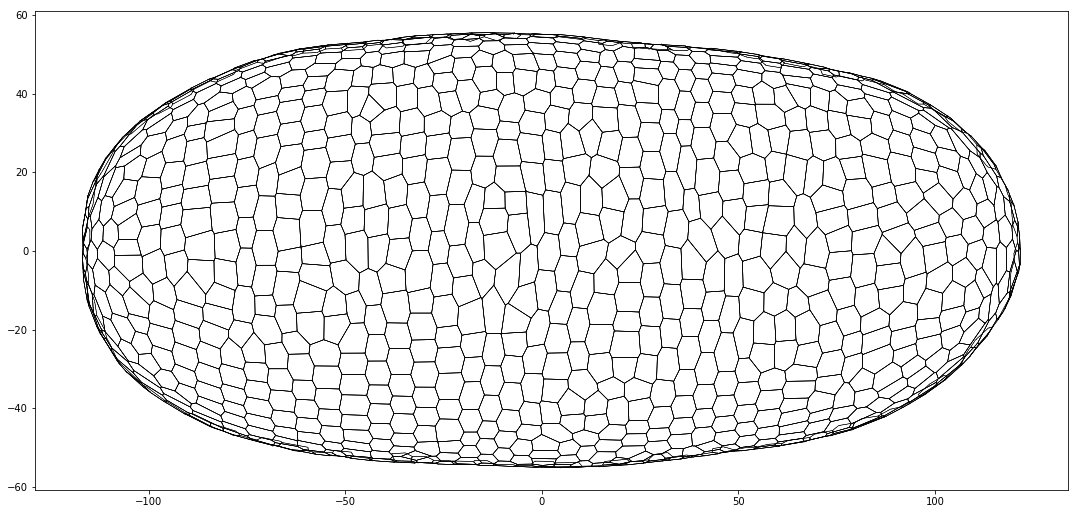

In [45]:
sheet2 = sheet.extract_bounding_box(x_boundary=(-10,150))
fig, ax = sheet_view(sheet2, coords=['z', 'y'], 
                    **draw_specs(sheet2))
fig.set_size_inches(18.5, 10.5, forward=True)
ax.grid(False)


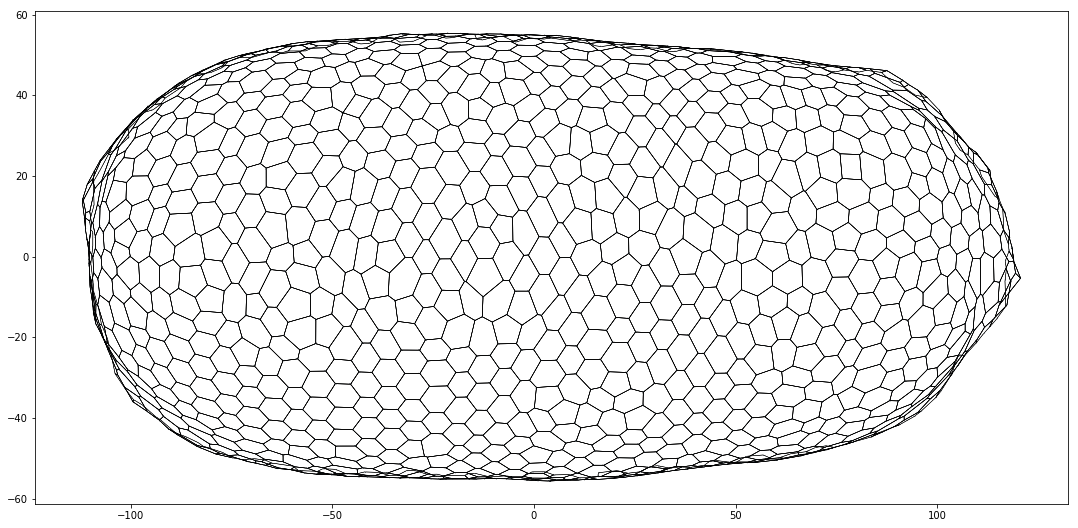

In [47]:
# relachement de la pré-polarité
sheet.edge_df.line_tension = 1
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})
sheet2 = sheet.extract_bounding_box(x_boundary=(-10,150))
fig, ax = sheet_view(sheet2, coords=['z', 'y'], 
                    **draw_specs(sheet2))
fig.set_size_inches(18.5, 10.5, forward=True)
ax.grid(False)


In [27]:
import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color': sheet.edge_df.line_tension,
            'colormap':"viridis"},
                      face={'color':'black', 'visible':True})
fig


Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…